# Inter-Maimi - PROD Retention Score _ all teams
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* June 20, 2022

## Hypothesis


## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt

from pycaret.classification import *

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
# connect to SQL Server.
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [3]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_all_teams] """
)

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"])

CNXN.commit()
cursor.close()

df.shape

(59948, 52)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59948 entries, 0 to 59947
Data columns (total 52 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   dimCustomerMasterId     59948 non-null  int64  
 1   year                    59948 non-null  int64  
 2   productGrouping         59948 non-null  object 
 3   totalSpent              59948 non-null  float64
 4   recentDate              59948 non-null  object 
 5   attendancePercent       59948 non-null  float64
 6   renewedBeforeDays       59927 non-null  float64
 7   isBuyer                 59948 non-null  object 
 8   source_tenure           59927 non-null  float64
 9   tenure                  59927 non-null  float64
 10  distToVenue             59948 non-null  float64
 11  totalGames              59948 non-null  int64  
 12  recency                 59948 non-null  int64  
 13  missed_games_1          59948 non-null  int64  
 14  missed_games_2          59948 non-null

### We should specify the features used in our model:

In [5]:
# choose the features for the stellar base retention model
features = [
            "dimCustomerMasterId",
            "year",
            "productGrouping", 
            "totalSpent", 
            "recentDate",
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2",
            "isNextYear_Buyer"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2021]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (43284, 15)
Unseen Data For Predictions: (7638, 15)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [6]:
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimCustomerMasterId","productGrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
    "totalSpent", 
            "attendancePercent", 
            "renewedBeforeDays",
            "source_tenure",
            "tenure",
            "distToVenue",
            "recency",
            "missed_games_1",
            "missed_games_2",
            "missed_games_over_2"
    ]
);

In [8]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm","lr","xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7826,0.8298,0.8995,0.7893,0.8408,0.5025,0.5133,0.4200
xgboost,Extreme Gradient Boosting,0.7801,0.8262,0.8893,0.7918,0.8377,0.5001,0.5083,1.7060
lr,Logistic Regression,0.7359,0.7589,0.8897,0.7457,0.8114,0.3826,0.3996,0.9410


In [9]:
lightgbm_model = create_model('lightgbm')
lr_model = create_model('lr')
xgboost_model = create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7845,0.8345,0.8885,0.7972,0.8403,0.5119,0.5191
1,0.7725,0.8183,0.8888,0.7837,0.8330,0.4807,0.4902
2,0.7885,0.8314,0.8931,0.7992,0.8435,0.5205,0.5282
3,0.7850,0.8353,0.8893,0.7973,0.8407,0.5129,0.5202
4,0.7711,0.8185,0.8829,0.7852,0.8312,0.4797,0.4877
5,0.7815,0.8290,0.8880,0.7940,0.8384,0.5043,0.5119
6,0.7812,0.8176,0.8905,0.7923,0.8386,0.5026,0.5109
7,0.7782,0.8288,0.8905,0.7891,0.8367,0.4949,0.5038
8,0.7755,0.8204,0.8863,0.7883,0.8345,0.4893,0.4975
9,0.7825,0.8284,0.8948,0.7917,0.8401,0.5042,0.5135


### Let's load in our 2021 season data and get retention scores using the model:

In [21]:
cursor = CNXN.cursor()

storedProc_scoring = (
    f"""Exec [stlrMLS].[ds].[getRetentionScoringModelData_staging2] """
)

df_scoring = pd.read_sql(storedProc_scoring, CNXN)

# apply some data transformations
df_scoring["year"] = pd.to_numeric(df_scoring["year"])

CNXN.commit()
cursor.close()

df_scoring.shape

(6909, 15)

In [22]:
df_inference = df_scoring.loc[df_scoring["year"] >= 2022]
df_inference = df_inference.fillna(0)
df_inference.shape

(2679, 15)

In [23]:
lightgbm_predictions = predict_model(lightgbm_model, data=df_inference, raw_score=True)
lr_predictions = predict_model(lr_model, data=df_inference, raw_score=True)
xgboost_predictions = predict_model(xgboost_model, data=df_inference, raw_score=True)

In [24]:
print(f"lightgbm:\n {lightgbm_predictions.Label.value_counts()}")
print(f"log reg:\n {lr_predictions.Label.value_counts()}")
print(f"xgboost:\n {xgboost_predictions.Label.value_counts()}")

lightgbm:
 0    2489
1     190
Name: Label, dtype: int64
log reg:
 0    2251
1     428
Name: Label, dtype: int64
xgboost:
 0    2391
1     288
Name: Label, dtype: int64


In [25]:
print(f"lightgbm:\n {lightgbm_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")
print(f"lr:\n {lr_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")
print(f"xgboost:\n {xgboost_predictions.Score_1.value_counts(bins=[0, 0.25, 0.5, 0.75, 1])}")

lightgbm:
 (-0.001, 0.25]    1963
(0.25, 0.5]        526
(0.5, 0.75]        188
(0.75, 1.0]          2
Name: Score_1, dtype: int64
lr:
 (-0.001, 0.25]    1655
(0.25, 0.5]        596
(0.5, 0.75]        412
(0.75, 1.0]         16
Name: Score_1, dtype: int64
xgboost:
 (-0.001, 0.25]    1532
(0.25, 0.5]        859
(0.5, 0.75]        251
(0.75, 1.0]         37
Name: Score_1, dtype: int64


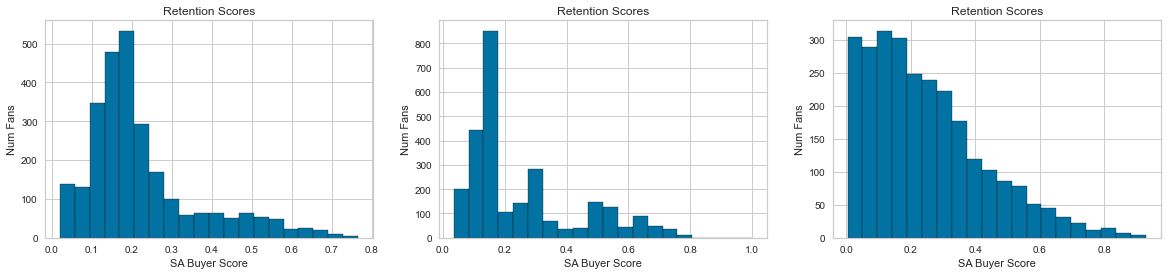

In [26]:
model_predictions = [lightgbm_predictions, lr_predictions, xgboost_predictions]

for idx, df_predictions in enumerate(model_predictions):

    plt.subplot(1, 3, idx+1)

    plt.hist(df_predictions["Score_1"], bins=20, edgecolor='black')
    plt.title("Retention Scores")
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")

plt.rcParams["figure.figsize"] = (20,4)
plt.show()

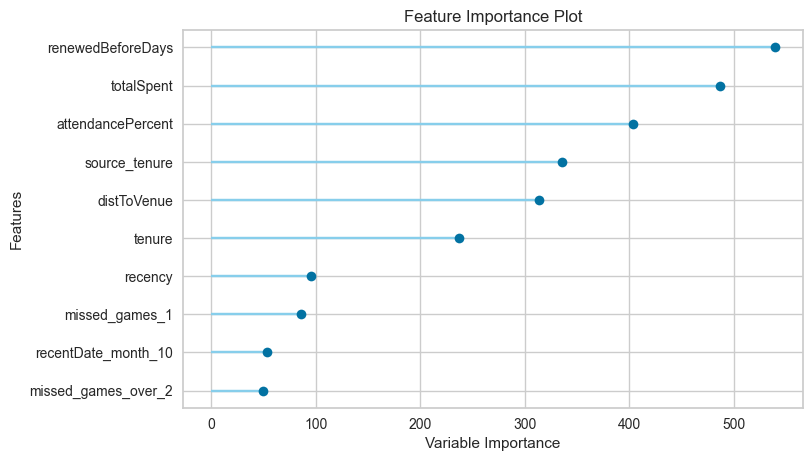

In [27]:
plot_model(lightgbm_model, plot='feature')

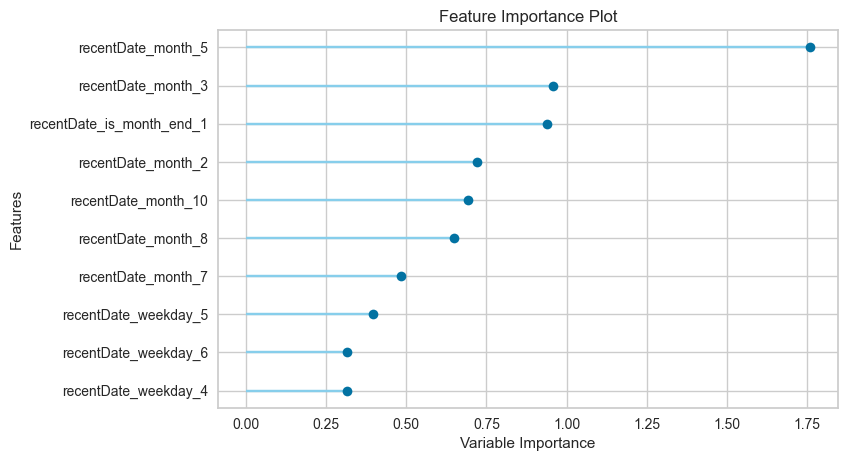

In [28]:
plot_model(lr_model, plot='feature')

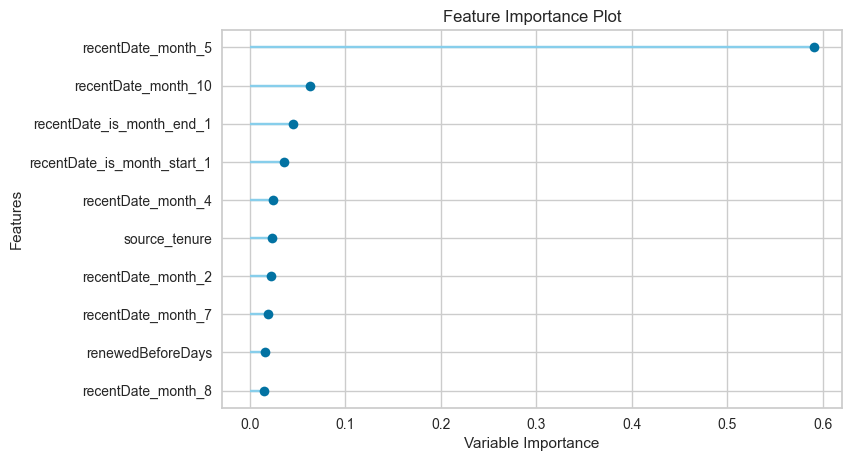

In [29]:
plot_model(xgboost_model, plot='feature')

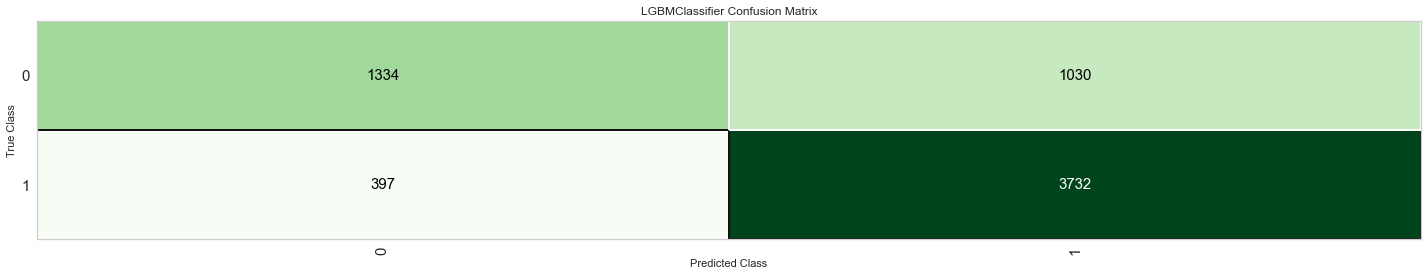

In [30]:
plot_model(lightgbm_model, plot='confusion_matrix')

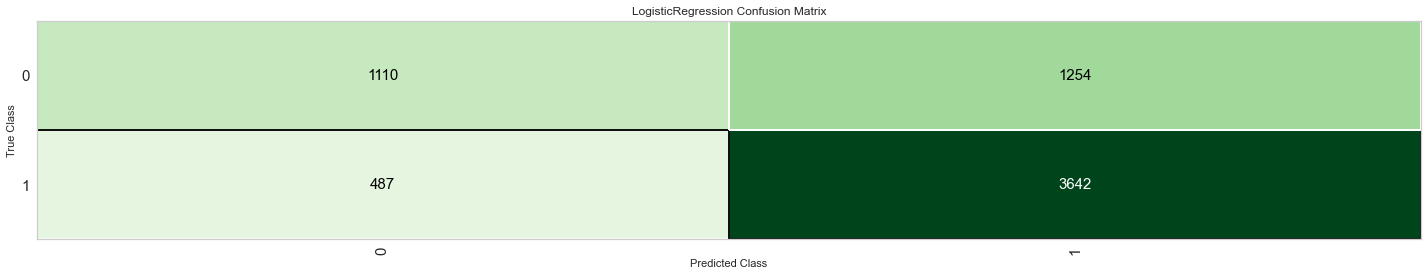

In [31]:
plot_model(lr_model, plot='confusion_matrix')

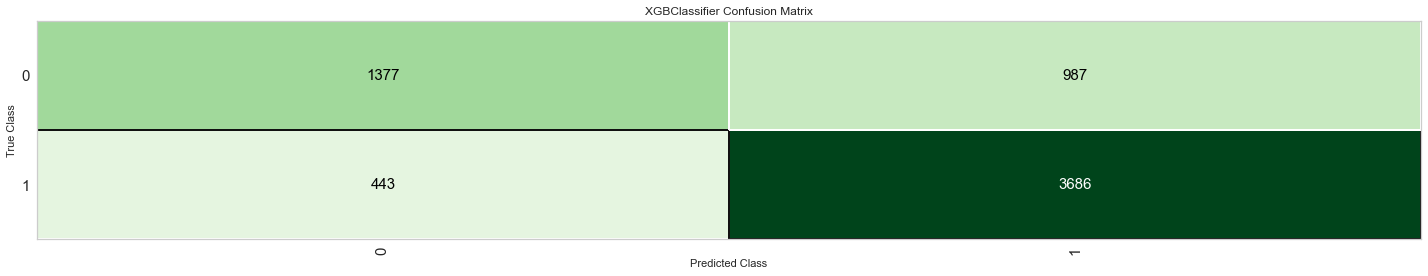

In [32]:
plot_model(xgboost_model, plot='confusion_matrix')

## Observations
Here you can document some ideas on the results from above